In [92]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import rc,cm,colorbar
import matplotlib.colors as mcolors

import glob
from scipy.interpolate import interp1d
from datetime import datetime
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 15}
rc('font', **font)

In [292]:
linecolors=['r','y','g','c','b','m','k']
letters=['a','b','c','d','e','f','g']
tfont = {'fontname':'Times'}
lake_list=['GreatBear','GreatSlave','Athabasca','Winnipegosis', 'Winnipeg']
#lake_list=['Superior','Huron','Michigan','Ontario', 'Erie']
nlake=len(lake_list)
model='76a'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_land=q.variables['LAKEMASK'][0]
D= q.variables['LAKE_DEPTH'][0]
wrf_lat=q.variables['XLAT']
wrf_lon=q.variables['XLONG']
nlat=len(wrf_lat[0])
nlon=len(wrf_lat[0][0])
#D_lake= np.sum(D*wrf_lake)/wrf_lake_sum
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
ntim=len(q.variables['H_ML_LAKE'])
nyear=int(ntim/12)
T_w=np.zeros((8,ntim,nlat,nlon))
T_w[0,:,:,:] = q.variables['H_ML_LAKE'][:] #mixing layer depth
T_w[1,:,:,:] = q.variables['T_WML_LAKE'][:]  #mixing layer T
T_w[4,:,:,:] = q.variables['H_ICE_LAKE'][:] #ice depth
T_w[5,:,:,:] = q.variables['T_ICE_LAKE'][:]  #Ice-snow T
T_w[5,:,:,:]=np.where(T_w[4,:,:,:] <= 0, T_w[1,:,:,:], T_w[5,:,:,:])
T_w[6,:,:,:] = q.variables['H_SNOW_LAKE'][:] #snow depth
T_w[7,:,:,:] = q.variables['T_SNOW_LAKE'][:]  #snow-air T
T_w[7,:,:,:]=np.where(T_w[6,:,:,:] <= 0, T_w[5,:,:,:], T_w[7,:,:,:])
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
T_w[2,:,:,:] = q.variables['T_BOT_LAKE'][:] 
T_w[3,:,:,:] = q.variables['C_T_LAKE'][:] #shape factor (thermocline)

In [293]:
layerontop=1; #1:water;2:water+ice;3:water+ice+snow
nlakelayer=25
T_w_lake=np.zeros( (nlake,8,ntim) )
Tw_lake_season=np.zeros( (nlake,8,nyear) )
D_lake= np.zeros( (nlake) )
D_lake_season= np.zeros( (nlake,nyear) )
z_flake=np.zeros( (nlake,nlakelayer+layerontop) )
Tw_lake_tprofile=np.zeros( (nlake,ntim,nlakelayer+layerontop) )
Tw_lake_season_tprofile=np.zeros( (nlake,nyear,nlakelayer+layerontop) )
eta=np.array(range(nlakelayer))/(nlakelayer-1)
for lakeid in range(0, 3):
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake=q.variables['mask_array']
    #wrf_lake_sum=np.sum(wrf_lake)
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]*wrf_land[ilat,ilon]>0:
                T_w_lake[lakeid,:,:]+=T_w[:,:,ilat,ilon]
                D_lake[lakeid]+=D[ilat,ilon]
    T_w_lake[lakeid,:,:]/=np.sum(wrf_lake*wrf_land>0)
    D_lake[lakeid]/=np.sum(wrf_lake*wrf_land>0)
    ### calculate T profile first and then average them over each lake and all time
    for i in range(0, nlakelayer): 
        z_flake[lakeid,i+layerontop]=eta[i]*(D_lake[lakeid]-np.mean(T_w_lake[lakeid,0,:]))+np.mean(T_w_lake[lakeid,0,:])    
    if layerontop >2: #==3
        for i in range(2, nlakelayer+layerontop): 
            z_flake[lakeid,i]+=np.mean(T_w_lake[lakeid,4,:])+np.mean(T_w_lake[lakeid,6,:])
        z_flake[lakeid,1]=np.mean(T_w_lake[lakeid,6,:])
        z_flake[lakeid,0]=0
    elif  layerontop >1: #==2
        for i in range(1, nlakelayer+layerontop): 
            z_flake[lakeid,i]+=np.mean(T_w_lake[lakeid,4,:])
        z_flake[lakeid,0]=0
    else:
        z_flake[lakeid,0]=0 #lake surface  
    count1=np.zeros((ntim,nlakelayer+layerontop))
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]*wrf_land[ilat,ilon]>0:
                z=np.zeros( (ntim,nlakelayer+layerontop) )
                tmp=np.zeros( (ntim,nlakelayer+layerontop) )
                #Tw_lake_season_tprofile=np.zeros( (nlake,nyear,nlakelayer+layerontop) )
                for i in range(0, nlakelayer): 
                    z[:,i]=eta[i]*(D[ilat,ilon]-T_w[0,:,ilat,ilon])+T_w[0,:,ilat,ilon]
                    phi=(40/3*T_w[3,:,ilat,ilon]-20/3)*eta[i]+(18-30*T_w[3,:,ilat,ilon])*eta[i]**2+(20*T_w[3,:,ilat,ilon]-12)*eta[i]**3+(5/3-10/3*T_w[3,:,ilat,ilon])*eta[i]**4
                    tmp[:,i+layerontop]=T_w[1,:,ilat,ilon]-(T_w[1,:,ilat,ilon]-T_w[2,:,ilat,ilon])*phi
                    #Tw_lake_season_tprofile[:,:,i+layerontop]=Tw_lake_season[:,1,:]-(Tw_lake_season[:,1,:]-Tw_lake_season[:,2,:])*phi
                z[:,0]=0#lake surface
                if layerontop >2: #==3
                    for i in range(2, nlakelayer+layerontop): 
                        z[:,i]+=T_w[4,:,ilat,ilon]+T_w[6,:,ilat,ilon]
                    tmp[:,2]=T_w[1,:,ilat,ilon]
                    z[:,1]=T_w[6,:,ilat,ilon]
                    tmp[:,1]=T_w[5,:,ilat,ilon]
                    tmp[:,0]=T_w[7,:,ilat,ilon]
                elif  layerontop >1: #==2
                    for i in range(1, nlakelayer+layerontop): 
                        z[:,i]+=T_w[4,:,ilat,ilon]
                    tmp[:,1]=T_w[1,:,ilat,ilon]
                    tmp[:,0]=T_w[5,:,ilat,ilon]
                else:
                    tmp[:,0]=T_w[1,:,ilat,ilon]
                for itim in range(0,ntim):
                    f = interp1d(z[itim], tmp[itim], bounds_error=False)
                    tmpz=f(z_flake[lakeid])
                    count1[itim]+=(~np.isnan(tmpz))
                    tmpz[np.isnan(tmpz)]=0
                    Tw_lake_tprofile[lakeid,itim]+=tmpz
    Tw_lake_tprofile[lakeid]/=count1
for itim in range(0, nyear):
    Tw_lake_season_tprofile[:,itim,:]=np.mean(Tw_lake_tprofile[:,itim*12+5:itim*12+8,:],axis=1) #JJA    
    Tw_lake_season_tprofile[:,itim,:]=(Tw_lake_tprofile[:,itim*12,:]+Tw_lake_tprofile[:,itim*12+1,:]+Tw_lake_tprofile[:,itim*12+11,:])/3 #DJF   
#    T_w_lake[itim]=np.sum(T_w[itim]*wrf_lake)/wrf_lake_sum


In [ ]:
count1[]

In [109]:
###run this if we want to first average shape function over each lake and all time and then calculate avg T profile
for itim in range(0, nyear):
    #Tw_lake_season[:,:,itim]=np.mean(T_w_lake[:,:,itim*12+5:itim*12+8],axis=2) #JJA
    #D_lake_season[:,itim]= np.mean(D_lake[:,itim*12+5:itim*12+8],axis=1) #JJA
    Tw_lake_season[:,:,itim]=(T_w_lake[:,:,itim*12]+T_w_lake[:,:,itim*12+1]+T_w_lake[:,:,itim*12+11])/3 #DJF
    D_lake_season[:,itim]=D_lake
eta=np.array(range(nlakelayer))/(nlakelayer-1)
z=np.zeros( (nlake,nyear,nlakelayer+layerontop) )
Tw_lake_season_tprofile=np.zeros( (nlake,nyear,nlakelayer+layerontop) )
for i in range(0, nlakelayer): 
    z[:,:,i+layerontop]=eta[i]*(D_lake_season-Tw_lake_season[:,0,:])+Tw_lake_season[:,0,:]
    phi=(40/3*Tw_lake_season[:,3,:]-20/3)*eta[i]+(18-30*Tw_lake_season[:,3,:])*eta[i]**2+(20*Tw_lake_season[:,3,:]-12)*eta[i]**3+(5/3-10/3*Tw_lake_season[:,3,:])*eta[i]**4
    Tw_lake_season_tprofile[:,:,i+layerontop]=Tw_lake_season[:,1,:]-(Tw_lake_season[:,1,:]-Tw_lake_season[:,2,:])*phi
if layerontop >2: #==3
    for i in range(2, nlakelayer+layerontop): 
        z[:,:,i]+=Tw_lake_season[:,4,:]+Tw_lake_season[:,6,:]
    Tw_lake_season_tprofile[:,:,2]=Tw_lake_season[:,1,:]
    z[:,:,1]=Tw_lake_season[:,6,:]
    Tw_lake_season_tprofile[:,:,1]=Tw_lake_season[:,5,:]
    z[:,:,0]=0
    Tw_lake_season_tprofile[:,:,0]=Tw_lake_season[:,7,:]
elif  layerontop >1: #==2
    for i in range(1, nlakelayer+layerontop): 
        z[:,:,i]+=Tw_lake_season[:,4,:]
    Tw_lake_season_tprofile[:,:,1]=Tw_lake_season[:,1,:]
    z[:,:,0]=0
    Tw_lake_season_tprofile[:,:,0]=Tw_lake_season[:,5,:]
else:
    z[:,:,0]=0 #lake surface
    Tw_lake_season_tprofile[:,:,0]=Tw_lake_season[:,1,:] 

In [278]:
model='67'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
T_w= q.variables['T_LAKE3D']
z=q.variables['Z_LAKE3D'][0];z[z<0]=np.nan #use the first month as Z_w for every month is identical
nlakelayer=len(z)
z_gl25=np.zeros((nlake,nlakelayer))
Tw_lake_gl25=np.zeros( (nlake,ntim,nlakelayer) )
Tw_lake_season_gl25=np.zeros( (nlake,nyear,nlakelayer) )
for lakeid in range(0, 3):
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake=q.variables['mask_array']
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]*wrf_land[ilat,ilon]>0:
                z_gl25[lakeid,:]+=z[:,ilat,ilon]
    z_gl25[lakeid,:]/=np.sum(wrf_lake*wrf_land>0)
    count1=np.zeros((ntim,nlakelayer))
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]*wrf_land[ilat,ilon]>0:
                for itim in range(0,ntim):
                    f = interp1d(z[:,ilat,ilon], T_w[itim,:,ilat,ilon], bounds_error=False)
                    tmpz=f(z_gl25[lakeid,:])
                    count1[itim,:]+=(~np.isnan(tmpz))
                    tmpz[np.isnan(tmpz)]=0
                    Tw_lake_gl25[lakeid,itim,:]+=tmpz
    Tw_lake_gl25[lakeid,:,:]/=count1
for itim in range(0, nyear):
    Tw_lake_season_gl25[:,itim,:]=np.mean(Tw_lake_gl25[:,itim*12+5:itim*12+8,:],axis=1) #JJA    
    Tw_lake_season_gl25[:,itim,:]=(Tw_lake_gl25[:,itim*12,:]+Tw_lake_gl25[:,itim*12+1,:]+Tw_lake_gl25[:,itim*12+11,:])/3 #DJF      

In [294]:
for itim in range(0, nyear):
    Tw_lake_season_tprofile[:,itim,:]=np.mean(Tw_lake_tprofile[:,itim*12+5:itim*12+8,:],axis=1) #JJA    
    Tw_lake_season_gl25[:,itim,:]=np.mean(Tw_lake_gl25[:,itim*12+5:itim*12+8,:],axis=1) #JJA   
#     Tw_lake_season_gl25[:,itim,:]=(Tw_lake_gl25[:,itim*12,:]+Tw_lake_gl25[:,itim*12+1,:]+Tw_lake_gl25[:,itim*12+11,:])/3 #DJF      
#     Tw_lake_season_tprofile[:,itim,:]=(Tw_lake_tprofile[:,itim*12,:]+Tw_lake_tprofile[:,itim*12+1,:]+Tw_lake_tprofile[:,itim*12+11,:])/3 #DJF   


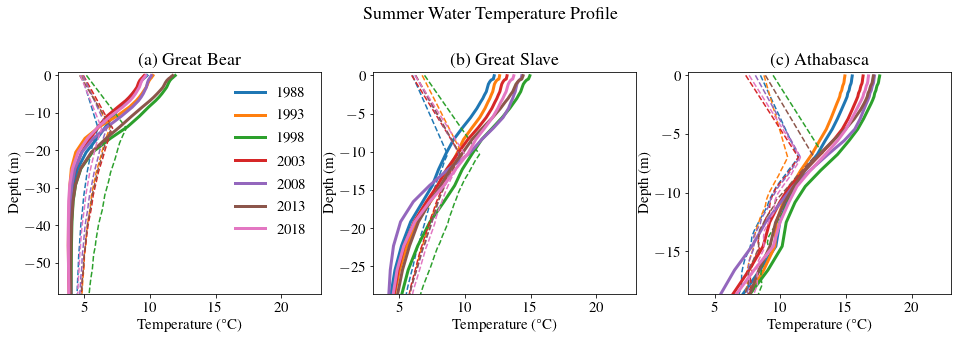

In [295]:
startyear=9;yeargap=5;
fig = plt.figure()
fig.set_size_inches(16, 9)
for lakeid in range(0, 3): 
    ax1 = fig.add_subplot(2,3,lakeid+1)
    ax1.title.set_text('('+letters[lakeid]+') '+lake_list[lakeid])
    if lakeid<2:
        ax1.title.set_text('('+letters[lakeid]+') '+lake_list[lakeid][0:5]+' '+lake_list[lakeid][5:])
    for i in range(startyear, nyear,yeargap): 
#        lines = plt.plot(Tw_lake_season_tprofile[lakeid,i,:]-273.15, -z[lakeid,i,:])
        line, = plt.plot(Tw_lake_season_gl25[lakeid,i,:]-273.15, -z_gl25[lakeid,:], linewidth=3,label=str(1979+i))
        colors=line.get_color()
        plt.plot(Tw_lake_season_tprofile[lakeid,i,:]-273.15, -z_flake[lakeid,:],c=colors,ls='--')        
        plt.ylabel('Depth (m)')
        plt.xlabel('Temperature (\N{DEGREE SIGN}C)')
        plt.axis([3, 23,-min(D_lake[lakeid],z_gl25[lakeid,nlakelayer-1]) ,min(D_lake[lakeid],z_gl25[lakeid,nlakelayer-1])/60])
        if lakeid==0:
            plt.legend(frameon=False)

plt.suptitle('Summer Water Temperature Profile')
fig.patch.set_facecolor('xkcd:white')
plt.show()
#fig.savefig('test2png.png', dpi=100)

In [181]:
endyear=2018;endmonth=12
lakeid=2;startyear=1990;startmonth=7;
#lakeid=0;startyear=2018;startmonth=9;
#lakeid=4;startyear=2017;startmonth=6;endyear=2017;endmonth=8
lakeid=1;startyear=2012;startmonth=11;

count=0
filelist=sorted(glob.glob("/scratch/p/peltier/huoyilin/CanadaLakeData/glerl_southern_lake_michigan_temperature_mooring_*.nc"))
#filelist=sorted(glob.glob("/scratch/p/peltier/huoyilin/CanadaLakeData/glerl_lake_superior_temperature_mooring_*.nc"))
#filelist=sorted(glob.glob("/scratch/p/peltier/huoyilin/CanadaLakeData/glerl_western_lake_erie_thermistor_string_*.nc"))
filelist=sorted(glob.glob("/scratch/p/peltier/huoyilin/CanadaLakeData/glerl_central_lake_huron_thermistor_string_*.nc"))
nfile=len(filelist)
if nfile>1:
    q=nc.Dataset(filelist[nfile-2])##for Michigan and Huron
else:
    q=nc.Dataset(filelist[0])
z_m=q.variables['z'][:].data
nlev=len(z_m)
#t1=time.gmtime(q.variables['time'][:])
q=nc.Dataset(filelist[0]);
moorstn_lon=q.variables['lon'][:].data
moorstn_lat=q.variables['lat'][:].data
z_tmp=q.variables['z'][:]
T_tmp=q.variables['sea_water_temperature'][:].data
T_tmp[T_tmp<-300]=np.nan
time_m=q.variables['time'][:]
ntim=len(T_tmp)
f = interp1d(z_tmp, T_tmp[0,:], fill_value="extrapolate")
T_m=f(z_m)
for itim in range(1,ntim):
    f = interp1d(z_tmp, T_tmp[itim,:], fill_value="extrapolate")
    T_m=np.c_[T_m,f(z_m)]
if nfile>1:
    for i in range(1, nfile):
        q=nc.Dataset(filelist[i]);
        moorstn_lon+=q.variables['lon'][:].data
        moorstn_lat+=q.variables['lat'][:].data
        z_tmp=q.variables['z'][:]
        T_tmp=q.variables['sea_water_temperature'][:].data
        T_tmp[T_tmp<-300]=np.nan
        time_m=np.append(time_m,q.variables['time'][:])
        ntim=len(T_tmp)
        #f = interp1d(z_tmp, T_tmp)
        #T_m=np.append(T_m,f(z_m))
        for itim in range(0,ntim):
            f = interp1d(z_tmp, T_tmp[itim,:], fill_value="extrapolate")
            T_m=np.c_[T_m,f(z_m)] 
np.savetxt('T_mooring_'+lake_list[lakeid]+'.dat', T_m) 
moorstn_lon/=nfile
moorstn_lat/=nfile


KeyboardInterrupt: 

In [40]:
T_m[T_m>40]=np.nan
#T_m[T_m<-4]=np.nan
ntim=len(time_m)
itim1=next((i for i in range(0,ntim) if datetime.fromtimestamp(time_m[i]) > datetime(startyear, startmonth, 1,0,0,0)),-999)
itim2=next((i for i in range(itim1,ntim) if datetime.fromtimestamp(time_m[i]) > datetime(endyear, endmonth, 31,23,59,59)),-999)
count=np.zeros((nlev,12))
T_m_s=np.zeros((nlev,12))
for i in range (itim1,itim2):
    imonth= datetime.fromtimestamp(time_m[i]).month-1
    T_tmp=T_m[:,i]
    notnanindex=~np.isnan(T_tmp)
    T_m_s[notnanindex,imonth]+=T_m[notnanindex,i]
    count[notnanindex,imonth]+=1
for imonth in range (0,12):
    T_m_s[:,imonth]=np.divide(T_m_s[:,imonth], count[:,imonth])

In [48]:
model='13'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_lat=q.variables['XLAT']
wrf_lon=q.variables['XLONG']
nlat=len(wrf_lat[0])
nlon=len(wrf_lat[0][0])
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
Z_w=q.variables['Z_LAKE3D'][:];Z_w[Z_w<0]=np.nan;
nmonth=len(Z_w);nlakelayer=len(Z_w[0]);
I_tmp = np.unravel_index(np.argmin((wrf_lat-moorstn_lat)**2+((wrf_lon-moorstn_lon)*np.cos(moorstn_lat* np.pi/180))**2), wrf_lat.shape)
I_row=I_tmp[1];I_col=I_tmp[2]
z_gl25=Z_w[0,:,I_row,I_col];
T_w=q.variables['T_LAKE3D'][:];T_w[T_w<1]=np.nan;
Tw_12month_gl25=np.zeros((nlakelayer,12))
imonth1=startmonth-1+12*(startyear-1979)
imonth2=endmonth+12*(endyear-1979)
for imonth in range (0,12):
    Tw_12month_gl25[:,imonth]=np.mean(T_w[imonth1+imonth:imonth2:12,:,I_row,I_col],axis=0)
Tw_12month_gl25=np.roll(Tw_12month_gl25, shift = startmonth-13, axis = 1)

In [51]:
###for FLAKE run the first part to load data first
Tw_lake_s=np.zeros( (8,12) )
for imonth in range (0,12):
    Tw_lake_s[:,imonth]=np.mean(T_w[:,imonth1+imonth:imonth2:12,I_row,I_col],axis=1)
Tw_lake_s=np.roll(Tw_lake_s, shift = startmonth-13, axis = 1)
D_lake=D[I_row,I_col]
layerontop=2; #1:water;2:water+ice;3:water+ice+snow
eta=np.array(range(nlakelayer))/(nlakelayer-1)
z_flake=np.zeros( (12,nlakelayer+layerontop) )
Tw_lake_s_tprofile=np.zeros( (12,nlakelayer+layerontop) )
for i in range(0, nlakelayer): 
    z_flake[:,i+layerontop]=eta[i]*(D_lake-Tw_lake_s[0,:])+Tw_lake_s[0,:]
    phi=(40/3*Tw_lake_s[3,:]-20/3)*eta[i]+(18-30*Tw_lake_s[3,:])*eta[i]**2+(20*Tw_lake_s[3,:]-12)*eta[i]**3+(5/3-10/3*Tw_lake_s[3,:])*eta[i]**4
    Tw_lake_s_tprofile[:,i+layerontop]=Tw_lake_s[1,:]-(Tw_lake_s[1,:]-Tw_lake_s[2,:])*phi
if layerontop >2: #==3
    for i in range(2, nlakelayer+layerontop): 
        z_flake[:,i]+=Tw_lake_s[4,:]+Tw_lake_s[6,:]
    Tw_lake_s_tprofile[:,2]=Tw_lake_s[1,:]
    z_flake[:,1]=Tw_lake_s[6,:]
    Tw_lake_s_tprofile[:,1]=Tw_lake_s[5,:]
    z_flake[:,0]=0
    Tw_lake_season_tprofile[:,:,0]=Tw_lake_season[:,7,:]
elif  layerontop >1: #==2
    for i in range(1, nlakelayer+layerontop): 
        z_flake[:,i]+=Tw_lake_s[4,:]
    Tw_lake_s_tprofile[:,1]=Tw_lake_s[1,:]
    z_flake[:,0]=0
    Tw_lake_s_tprofile[:,0]=Tw_lake_s[5,:]
else:
    z_flake[:,0]=0 #lake surface
    Tw_lake_s_tprofile[:,0]=Tw_lake_s[1,:] 

In [52]:
Tw_12month_gl25=np.roll(Tw_12month_gl25, shift = 3, axis = 1)
Tw_lake_s_tprofile=np.roll(Tw_lake_s_tprofile, shift = 3, axis = 0)
T_m_s=np.roll(T_m_s, shift = 3, axis = 1)
Tw_lake_s_tprofile_z=T_m_s*0
Tw_12month_gl25_z=T_m_s*0
for imonth in range(0,12):
    f = interp1d(z_gl25,Tw_12month_gl25[:,imonth], fill_value="extrapolate")
    Tw_12month_gl25_z[:,imonth]=f(z_m)
    f = interp1d(z_flake[imonth,:],Tw_lake_s_tprofile[imonth,:], fill_value="extrapolate")
    Tw_lake_s_tprofile_z[:,imonth]=f(z_m)

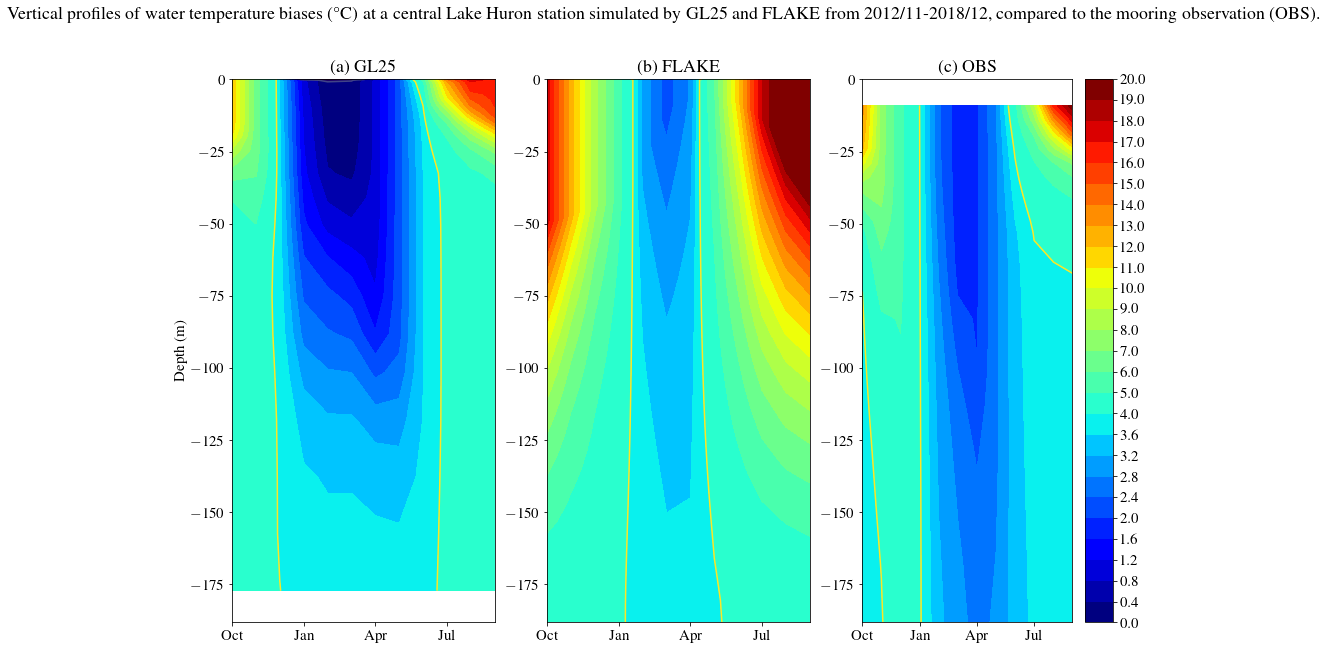

In [54]:
v1=0;v2=26#Michigan
#v1=2;v2=18 #Superior
#v1=6;v2=28 #Erie
v1=0;v2=20 #Huron
#v1=-10;v2=-v1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))
nbound=int((v2-5)/1)+1
bounds=np.linspace(v1,v2,nbound)
uneven_levels=np.hstack([np.linspace(v1,4,11), np.linspace(5,v2,nbound)])
cmap_rb = plt.get_cmap('jet')
colors = cmap_rb(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)

#ax1 = fig.add_subplot(1,3,1)
ax1= axes.flat[0];
ax1.title.set_text('(a) GL25')
im=ax1.contourf(np.array(range(1,13)), -z_gl25, Tw_12month_gl25-273.15,cmap=cm.jet,vmin=v1, vmax=v2, levels = bounds,extend = 'both') 
im = ax1.contourf(np.array(range(1,13)), -z_gl25, Tw_12month_gl25-273.15, cmap=cmap, norm=norm, levels =uneven_levels)
ax1.contour(np.array(range(1,13)), -z_gl25, Tw_12month_gl25-273.15, [-1,0,4]) 
#im=ax1.contourf(np.array(range(1,13)), -z_m, Tw_12month_gl25_z-273.15-T_m_s,cmap='seismic',vmin=v1, vmax=v2, levels = bounds,extend = 'both') 
ax1.set_ylabel('Depth (m)')
ax1.set_ylim([-min(z_m[-1],z_flake[0,-1]) ,0.2])
#ax1.set_ylim([-z_m[-1] ,0.2])
if startyear==endyear:
    xlim1=startmonth
    xlim2=endmonth
else:
    xlim1=1
    xlim2=12
ax1.set_xlim([xlim1 ,xlim2])
ax1= axes.flat[1];
ax1.title.set_text('(b) FLAKE')
xmonth=z_flake*0
for i in range(0,12):
    xmonth[i,:]=i+1
im=ax1.contourf(xmonth, -z_flake, Tw_lake_s_tprofile-273.15,cmap=cm.jet,vmin=v1, vmax=v2, levels = bounds,extend = 'both')  
im = ax1.contourf(xmonth, -z_flake,Tw_lake_s_tprofile-273.15, cmap=cmap, norm=norm, levels =uneven_levels)
ax1.contour(xmonth, -z_flake, Tw_lake_s_tprofile-273.15, [-1,0,4]) 
#im=ax1.contourf(np.array(range(1,13)), -z_m, Tw_lake_s_tprofile_z-273.15-T_m_s,cmap='seismic',vmin=v1, vmax=v2, levels = bounds,extend = 'both') 
ax1.set_ylim([-min(z_m[-1],z_flake[0,-1]) ,0.2])
#ax1.set_ylim([-z_m[-1],0.2])
ax1.set_xlim([xlim1 ,xlim2])
ax1= axes.flat[2];
ax1.title.set_text('(c) OBS')
ax1.contourf(np.array(range(1,13)), -z_m, T_m_s,cmap=cm.jet,vmin=v1, vmax=v2, levels = bounds,extend = 'both')
im = ax1.contourf(np.array(range(1,13)), -z_m, T_m_s, cmap=cmap, norm=norm, levels =uneven_levels)
ax1.contour(np.array(range(1,13)), -z_m, T_m_s, [0,4]) 
ax1.set_ylim([-min(z_m[-1],z_flake[0,-1]) ,0.2])
ax1.set_xlim([xlim1 ,xlim2])
plt.suptitle('Vertical profiles of water temperature biases (\N{DEGREE SIGN}C) at a central Lake '+lake_list[lakeid]+' station simulated by GL25 and FLAKE from '+str(startyear)+'/'+str(startmonth)+'-'+str(endyear)+'/'+str(endmonth)+', compared to the mooring observation (OBS).')  
#plt.setp(axes, xticks=[1, 4, 7,10], xticklabels=['Jan', 'Apr', 'Jul','Oct'])
plt.setp(axes, xticks=[1, 4, 7,10], xticklabels=['Oct', 'Jan', 'Apr','Jul'])
#plt.setp(axes, xticks=[9,10,11,12], xticklabels=['Sep', 'Oct', 'Nov','Dec'])
#plt.setp(axes, xticks=[6,7,8], xticklabels=['Jun', 'Jul', 'Aug'])
cbar = fig.colorbar(im, ticks=uneven_levels)
#cbar = fig.colorbar(im, ax=axes.ravel().tolist())#, orientation = 'horizontal'
fig.patch.set_facecolor('xkcd:white')
plt.show()

In [169]:
#Tw_12month_gl25_2=Tw_12month_gl25
#Tw_lake_s_tprofile_2=Tw_lake_s_tprofile
#z_gl25_2=z_gl25
#z_flake_2=z_flake
z_m_2=z_m
T_m_s_2=T_m_s

ValueError: operands could not be broadcast together with shapes (18,3) (21,3) 

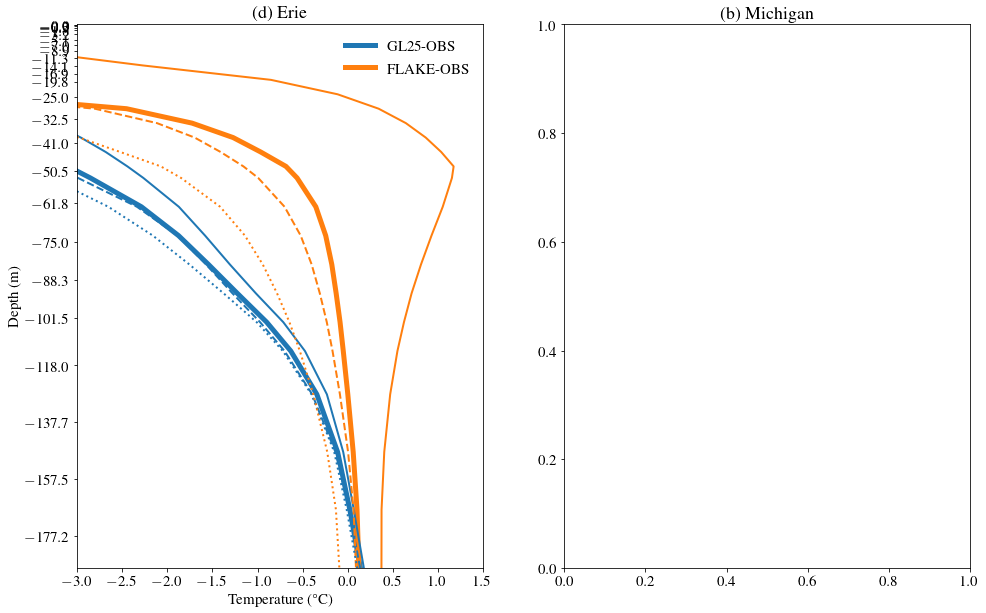

In [167]:
monthname=['Jan.','Feb.','March','April','May','June','July','Aug.','Sept.','Oct.','Nov.','Dec.']
fig, ax = plt.subplots()
#fig = plt.figure()
fig.set_size_inches(16, 10)
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
#ax1 = fig.add_subplot(1,2,1)
month1=0;month2=3
months=range(month1,month2)
linestyles=['-','--','-.',':']
linestyles=['-','--',':']
colors=['12345678','12345678','12345678']
xlim1=-1.5;xlim2=6
xlim1=-3;xlim2=1.5
ax1 = plt.subplot(1,2,1)
#ax1 = plt.subplot("122")
#ax1= axes.flat[lakeid];
ax1.title.set_text('('+letters[lakeid-1]+') '+lake_list[lakeid]) 
#line, =plt.plot((Tw_12month_gl25[:,0]+Tw_12month_gl25[:,1]+Tw_12month_gl25[:,11])/3-273.15, -z_gl25, linewidth=5, label='GL25')
#line, =plt.plot(np.mean(Tw_12month_gl25[:,month1:month2],axis=1)-273.15, -z_gl25, linewidth=5, label='GL25')
line, =plt.plot(np.mean(Tw_12month_gl25_z[:,month1:month2]-T_m_s[:,month1:month2],axis=1)-273.15, -z_m, linewidth=5, label='GL25-OBS') 
colors[0]=line.get_color()
#line, =plt.plot((Tw_lake_s_tprofile[0,:]+Tw_lake_s_tprofile[1,:]+Tw_lake_s_tprofile[11,:])/3-273.15, -(z_flake[0,:]+z_flake[1,:]+z_flake[11,:])/3, linewidth=5, label='FLAKE') 
#line, =plt.plot(np.mean(Tw_lake_s_tprofile[month1:month2,:],axis=0)-273.15, -np.mean(z_flake[month1:month2,:],axis=0), linewidth=5, label='FLAKE') 
line, =plt.plot(np.mean(Tw_lake_s_tprofile_z[:,month1:month2]-T_m_s[:,month1:month2],axis=1)-273.15, -z_m, linewidth=5, label='FLAKE-OBS') 
colors[1]=line.get_color()
#line, =plt.plot((T_m_s[:,0]+T_m_s[:,1]+T_m_s[:,11])/3, -z_m, linewidth=5, label='OBS') 
#line, =plt.plot(np.mean(T_m_s[:,month1:month2],axis=1), -z_m, linewidth=5, label='OBS') 
colors[2]=line.get_color()
for i in range(0,len(months)):
    imonth=months[i]
    #plt.plot(Tw_12month_gl25[:,imonth]-273.15, -z_gl25,c=colors[0],ls=linestyles[i], linewidth=2)
    #plt.plot(Tw_lake_s_tprofile[imonth,:]-273.15, -z_flake[imonth,:], c=colors[1],ls=linestyles[i],linewidth=2) 
    #plt.plot(T_m_s[:,imonth], -z_m,c=colors[2],ls=linestyles[i], linewidth=2) 
    plt.plot(Tw_12month_gl25_z[:,imonth]-T_m_s[:,imonth]-273.15, -z_m, c=colors[0],ls=linestyles[i],linewidth=2) 
    plt.plot(Tw_lake_s_tprofile_z[:,imonth]-T_m_s[:,imonth]-273.15, -z_m, c=colors[1],ls=linestyles[i],linewidth=2) 

ax1.legend(frameon=False)
plt.ylabel('Depth (m)') 
plt.xlabel('Temperature (\N{DEGREE SIGN}C)') 
plt.yticks(ticks=-z_gl25)
ax1.axis([xlim1, xlim2,-min(z_m[-1],z_flake[0,nlakelayer+layerontop-1]) ,0.2]) 
#ax1.axis([xlim1, xlim2,-15 ,0.2]) 
ax1 = plt.subplot(1,2,2)
#ax1 = plt.subplot("122")
#ax1= axes.flat[lakeid];
ax1.title.set_text('('+letters[2-1]+') '+lake_list[2]) 
#plt.plot((Tw_12month_gl25_2[:,0]+Tw_12month_gl25_2[:,1]+Tw_12month_gl25_2[:,11])/3-273.15, -z_gl25_2, linewidth=5, label='GL25')
#plt.plot((Tw_lake_s_tprofile_2[0,:]+Tw_lake_s_tprofile_2[1,:]+Tw_lake_s_tprofile_2[11,:])/3-273.15, -(z_flake_2[0,:]+z_flake_2[1,:]+z_flake_2[11,:])/3, linewidth=5, label='FLAKE') 
#plt.plot((T_m_s_2[:,0]+T_m_s_2[:,1]+T_m_s_2[:,11])/3, -z_m_2, linewidth=5, label='OBS') 
#plt.plot(np.mean(Tw_12month_gl25_2[:,month1:month2],axis=1)-273.15, -z_gl25_2, linewidth=5, label='GL25')
#plt.plot(np.mean(Tw_lake_s_tprofile_2[month1:month2,:],axis=0)-273.15, -np.mean(z_flake_2[5:8,:],axis=0), linewidth=5, label='FLAKE') 
#plt.plot(np.mean(T_m_s_2[:,month1:month2],axis=1), -z_m_2, linewidth=5, label='OBS') 
plt.plot(np.mean(Tw_12month_gl25_2z[:,month1:month2]-T_m_s_2[:,month1:month2],axis=1)-273.15, -z_m_2, linewidth=5, label='GL25-OBS') 
plt.plot(np.mean(Tw_lake_s_tprofile_2z[:,month1:month2]-T_m_s_2[:,month1:month2],axis=1)-273.15, -z_m_2, linewidth=5, label='FLAKE-OBS') 

for i in range(0,len(months)):
    imonth=months[i]
    #plt.plot(Tw_12month_gl25_2[:,imonth]-273.15, -z_gl25_2,c=colors[0],ls=linestyles[i], linewidth=2)
    #plt.plot(Tw_lake_s_tprofile_2[imonth,:]-273.15, -z_flake_2[imonth,:], c=colors[1],ls=linestyles[i],linewidth=2) 
    #plt.plot(T_m_s_2[:,imonth], -z_m_2,c=colors[2],ls=linestyles[i], linewidth=2) 
    plt.plot(Tw_12month_gl25_2z[:,imonth]-T_m_s_2[:,imonth]-273.15, -z_m_2, c=colors[0],ls=linestyles[i],linewidth=2) 
    plt.plot(Tw_lake_s_tprofile_2z[:,imonth]-T_m_s_2[:,imonth]-273.15, -z_m_2, c=colors[1],ls=linestyles[i],linewidth=2) 
#ax1.legend(frameon=False)
plt.ylabel('Depth (m)') 
plt.xlabel('Temperature (\N{DEGREE SIGN}C)') 
plt.yticks(ticks=-z_gl25_2)
ax1.axis([xlim1, xlim2,-min(z_m_2[-1],z_flake_2[0,nlakelayer+layerontop-1]),0.2]) 
#ax1.axis([xlim1, xlim2,-15 ,0.2]) 
plt.suptitle('Winter Water Temperature Profile') 
fig.patch.set_facecolor('xkcd:white')
plt.show() 
#fig.savefig('test2png.png', dpi=100)

In [116]:
Tw_lake_s_tprofile_z=T_m_s*0
Tw_12month_gl25_z=T_m_s*0
for imonth in range(0,12):
    f = interp1d(z_gl25,Tw_12month_gl25[:,imonth], fill_value="extrapolate")
    Tw_12month_gl25_z[:,imonth]=f(z_m)
    f = interp1d(z_flake[imonth,:],Tw_lake_s_tprofile[imonth,:], fill_value="extrapolate")
    Tw_lake_s_tprofile_z[:,imonth]=f(z_m)

In [770]:
with open('FLAKETProfile'+model+lake_list[lakeid]+'.txt', 'w') as outfile:
    iyear=0
    for slice_2d in z:
        outfile.write(z[iyear]+'\n')
        np.savetxt(outfile, slice_2d, fmt='%-8.5f')
        iyear+=1
    iyear=0
    for slice_2d in Tw_lake_season_tprofile:
        outfile.write(Tw_lake_season_tprofile[iyear]-273.15+'\n')
        np.savetxt(outfile, slice_2d, fmt='%-8.5f')
        iyear+=1

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [163]:
np.savetxt('T_mooring_Michigan_Interp1dToz_m.dat', T_m)

In [91]:
(T_m_s[:,0]+T_m_s[:,1]+T_m_s[:,11])/3
z_m
Tw_lake_s_tprofile.shape
Tw_12month_gl25.shape
z_flake
Tw_lake_s_tprofile_2-Tw_lake_s_tprofile
#(Tw_12month_gl25[:,0]+Tw_12month_gl25[:,1]+Tw_12month_gl25[:,11])/3-273.15
#(Tw_lake_s_tprofile_2[0,:]+Tw_lake_s_tprofile_2[1,:]+Tw_lake_s_tprofile_2[11,:])/3-273.15
colors1

ValueError: operands could not be broadcast together with shapes (12,27) (12,26) 

In [189]:
data = np.loadtxt('T_mooring_Michigan_Interp1dToz_m.dat')

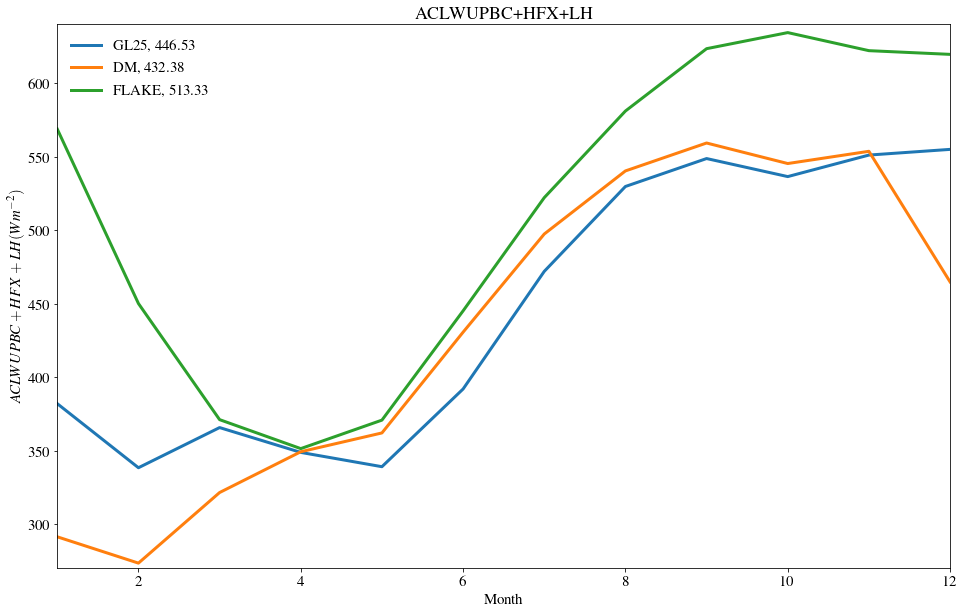

In [127]:
colors=['12345678','12345678','12345678','12345678','12345678']
fig = plt.figure()
fig.set_size_inches(16, 10)
model='13'#GL25
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
T_w=q.variables['T_LAKE3D'][:];T_w[T_w<1]=np.nan
ntim=len(T_w);nlat=len(T_w[0][0]);nlon=len(T_w[0][0][0])
R_w=q.variables['ALBEDO'][:]
#LAKE_ICEFRAC3D = q.variables['LAKE_ICEFRAC3D'][:];LAKE_ICEFRAC3D[LAKE_ICEFRAC3D<0]=np.nan;
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
R_w=q.variables['ACLWUPB'][:]
#R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
#R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
#T2_w=q.variables['T2'][:];T2_w[T2_w<1]=np.nan
R_w+=q.variables['HFX'][:]+q.variables['LH'][:]#LH
T_w_lake=np.zeros( (nlake,ntim) )
Tw_lake_season=np.zeros( (nlake,12) )
wrf_lake=np.zeros( (nlat,nlon) )
for lakeid in range(0, nlake):
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake+=q.variables['mask_array']
    #wrf_lake_sum=np.sum(wrf_lake)
    count=0
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]>0.1 and T_w[1,1,ilat,ilon]>1:
                count+=1
                #for itim in range(0,ntim):
                    #ilayer=next((i for i in range(0,nlakelayer) if LAKE_ICEFRAC3D[itim,i,ilat,ilon] <=0),-999)
                    #T_w_lake[lakeid,itim]+=T2_w[itim,ilat,ilon]-T_w[itim,ilayer,ilat,ilon]
                T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
    T_w_lake[lakeid,:]/=count
for lakeid in range(nlake-1, nlake):
    for imonth in range(0,12):
        Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
    annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
    line, =plt.plot(range(1,13),Tw_lake_season[lakeid,:], linewidth=3, label='GL25, '+annualavg)#lake_list[lakeid]) 
#     colors[lakeid]=line.get_color()
# q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
# #R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
# R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
# T_w_lake=np.zeros( (nlake,ntim) )
# Tw_lake_season=np.zeros( (nlake,12) )
# wrf_lake=np.zeros( (nlat,nlon) )
# for lakeid in range(0, nlake):
#     q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
#     wrf_lake+=q.variables['mask_array']
#     #wrf_lake_sum=np.sum(wrf_lake)
#     count=0
#     for ilat in range(0, nlat):
#         for ilon in range(0, nlon):
#             if wrf_lake[ilat,ilon]>0.1 and T_w[1,1,ilat,ilon]>1:
#                 count+=1
#                 #for itim in range(0,ntim):
#                     #ilayer=next((i for i in range(0,nlakelayer) if LAKE_ICEFRAC3D[itim,i,ilat,ilon] <=0),-999)
#                     #T_w_lake[lakeid,itim]+=T2_w[itim,ilat,ilon]-T_w[itim,ilayer,ilat,ilon]
#                 T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
#     T_w_lake[lakeid,:]/=count
# for lakeid in range(nlake-1, nlake):
#     for imonth in range(0,12):
#         Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
#     annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
#     plt.plot(range(1,13),Tw_lake_season[lakeid,:], linewidth=3,c=colors[lakeid],ls='--' ,label='GL25, '+annualavg)#lake_list[lakeid]) 

model='14' #DM
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
R_w=q.variables['ACLWUPB'][:]
#R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
#R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
#R_w=q.variables['ALBEDO'][:]
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
R_w+=q.variables['HFX'][:]+q.variables['LH'][:]#LH
T_w_lake=np.zeros( (nlake,ntim) )
Tw_lake_season=np.zeros( (nlake,12) )
wrf_lake=np.zeros( (nlat,nlon) )
for lakeid in range(0, nlake):
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake+=q.variables['mask_array']
    count=0
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]>0.1 and T_w[1,1,ilat,ilon]>1:
                count+=1
                T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
    T_w_lake[lakeid,:]/=count
for lakeid in range(nlake-1, nlake):
    for imonth in range(0,12):
        Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
    annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
    line, =plt.plot(range(1,13),Tw_lake_season[lakeid,:], linewidth=3,label='DM, '+annualavg)# ,ls=':',c=colors[lakeid]
#    colors[lakeid]=line.get_color()
# q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
# #R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
# R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
# T_w_lake=np.zeros( (nlake,ntim) )
# Tw_lake_season=np.zeros( (nlake,12) )
# wrf_lake=np.zeros( (nlat,nlon) )
# for lakeid in range(0, nlake):
#     q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
#     wrf_lake+=q.variables['mask_array']
#     count=0
#     for ilat in range(0, nlat):
#         for ilon in range(0, nlon):
#             if wrf_lake[ilat,ilon]>0.1 and T_w[1,1,ilat,ilon]>1:
#                 count+=1
#                 T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
#     T_w_lake[lakeid,:]/=count
# for lakeid in range(nlake-1, nlake):
#     for imonth in range(0,12):
#         Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
#     annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
#     plt.plot(range(1,13),Tw_lake_season[lakeid,:], linewidth=3,c=colors[lakeid],ls='--',label='DM, '+annualavg)# ,ls=':',c=colors[lakeid]

model='78g'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
T2_w=q.variables['T2'][:];T2_w[T2_w<1]=np.nan;
T_w = q.variables['T_WML_LAKE'][:]  #mixing layer T
R_w=q.variables['HFX'][:]+q.variables['LH'][:]#LH
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
R_w+=q.variables['ACLWUPB'][:]
#R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
#R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
#q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
#R_w=q.variables['ALBEDO'][:]
ntim=len(T_w)
T_w_lake=np.zeros( (nlake,ntim) )
Tw_lake_season=np.zeros( (nlake,12) )
wrf_lake=np.zeros( (nlat,nlon) )
for lakeid in range(0, nlake):
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake+=q.variables['mask_array']
    #wrf_lake_sum=np.sum(wrf_lake)
    count=0
    for ilat in range(0, nlat):
        for ilon in range(0, nlon):
            if wrf_lake[ilat,ilon]>0.1 and T_w[1,ilat,ilon]>1:
                count+=1
                #T_w_lake[lakeid,:]+=T2_w[:,ilat,ilon]-T_w[:,ilat,ilon]
                T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
    T_w_lake[lakeid,:]/=count
for lakeid in range(nlake-1, nlake):
    for imonth in range(0,12):
        Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
    annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
    line, =plt.plot(range(1,13),Tw_lake_season[lakeid,:],linewidth=3,label='FLAKE, '+annualavg) #,ls='--',c=colors[lakeid]
#    colors[lakeid]=line.get_color()
# q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
# #R_w=q.variables['NetLWRadiation'][:]#q.variables['NetRadiation'][:]-
# R_w=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
# T_w_lake=np.zeros( (nlake,ntim) )
# Tw_lake_season=np.zeros( (nlake,12) )
# wrf_lake=np.zeros( (nlat,nlon) )
# for lakeid in range(0, nlake):
#     q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
#     wrf_lake+=q.variables['mask_array']
#     #wrf_lake_sum=np.sum(wrf_lake)
#     count=0
#     for ilat in range(0, nlat):
#         for ilon in range(0, nlon):
#             if wrf_lake[ilat,ilon]>0.1 and T_w[1,ilat,ilon]>1:
#                 count+=1
#                 #T_w_lake[lakeid,:]+=T2_w[:,ilat,ilon]-T_w[:,ilat,ilon]
#                 T_w_lake[lakeid,:]+=R_w[:,ilat,ilon]
#     T_w_lake[lakeid,:]/=count
# for lakeid in range(nlake-1, nlake):
#     for imonth in range(0,12):
#         Tw_lake_season[lakeid,imonth]=np.mean(T_w_lake[lakeid,imonth:ntim:12])
#     annualavg= str(round(np.mean(Tw_lake_season[lakeid,:]),2))
#     plt.plot(range(1,13),Tw_lake_season[lakeid,:],linewidth=3,c=colors[lakeid],ls='--',label='FLAKE, '+annualavg) #,ls='--',c=colors[lakeid]

#plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([1, 12])
#plt.ylim([-390,260])
plt.ylim([270,640])
plt.xlabel('Month') 
#plt.ylabel('Temperature (\N{DEGREE SIGN}C)') 
plt.ylabel(r'$ACLWUPBC (J m^{-2} s^{-1})$') 
#plt.ylabel(r'$NetRadiation-HFX-LH (W m^{-2})$')
plt.ylabel(r'$ACLWUPBC+HFX+LH (W m^{-2})$')
#plt.ylabel('Albedo')
plt.legend(frameon=False)
#plt.title('T2-Twater')
plt.title('ACLWUPBC+HFX+LH')
fig.patch.set_facecolor('xkcd:white')
plt.show() 

In [ ]:
count